In [2]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from mini_imagenet_dataset import MiniImageNetDataset
from tools import getDataset, print_class_distribution

import numpy as np

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS device not found.")
print('Device:', device)

Device: mps


In [4]:
root_dir = os.path.join(os.getcwd(), 'datasets/miniImageNet')
dataset, label_mapping = getDataset(root_dir, shuffle_images=True)

train_dataset = MiniImageNetDataset(dataset=dataset, path=root_dir, phase='train', shuffle_images=True, transform=None)
val_dataset = MiniImageNetDataset(dataset=dataset, path=root_dir, phase='val', shuffle_images=True, transform=None)
test_dataset = MiniImageNetDataset(dataset=dataset, path=root_dir, phase='test', shuffle_images=True, transform=None)


In [5]:
batch_size = 64
num_workers = 4
learning_rate = 0.01
num_epochs = 10

root_dir = os.path.join(os.getcwd(), 'datasets/miniImageNet')
dataset, label_mapping = getDataset(root_dir, shuffle_images=True)


train_transforms = transforms.Compose(
        [
            transforms.Resize((84, 84)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )

transforms = transforms.Compose(
        [
            transforms.Resize((84, 84)),
            transforms.ToTensor(),
        ]
    )
       
       
train_dataset = MiniImageNetDataset(dataset=dataset, path=root_dir, phase='train', shuffle_images=True, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = MiniImageNetDataset(dataset=dataset, path=root_dir, phase='val', shuffle_images=True, transform=transforms)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_dataset = MiniImageNetDataset(dataset=dataset, path=root_dir, phase='test', shuffle_images=True, transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing/evaluating -> batch: %d correct: %d numb images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, valid_loader):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params= net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0  # used to accumulate number of correctly recognized images
        num_images = 0.0  # used to accumulate number of images
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_eval, val_loss = eval(net, valid_loader)
        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        val_losses.append(val_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_eval))

        scheduler.step()

    return net, training_losses, val_losses

Hyperparameters:
Batch Size: 64
Learning Rate: 0.001
Number of Epochs: 10
Number of Workers: 4
training -> epoch: 0, batch: 562, loss: 3.668384
testing/evaluating -> batch: 187 correct: 771 numb images: 12000
epoch: 0, lr: 0.010000, accuracy: 0.081139, loss: 4.100140, valid accuracy: 0.064250
training -> epoch: 1, batch: 562, loss: 3.058294
testing/evaluating -> batch: 187 correct: 2423 numb images: 12000
epoch: 1, lr: 0.010000, accuracy: 0.180028, loss: 3.434090, valid accuracy: 0.201917
training -> epoch: 2, batch: 562, loss: 2.623161
testing/evaluating -> batch: 187 correct: 2950 numb images: 12000
epoch: 2, lr: 0.010000, accuracy: 0.253139, loss: 3.028945, valid accuracy: 0.245833
training -> epoch: 3, batch: 562, loss: 2.758866
testing/evaluating -> batch: 187 correct: 2937 numb images: 12000
epoch: 3, lr: 0.010000, accuracy: 0.310528, loss: 2.735857, valid accuracy: 0.244750
training -> epoch: 4, batch: 562, loss: 2.827518
testing/evaluating -> batch: 187 correct: 2679 numb image

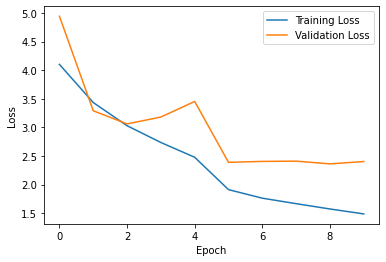

In [18]:
from models.resnet18 import ResNet18

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}\n")

# print_class_distribution(train_dataset, "Training", label_mapping)
# print_class_distribution(val_dataset, "Validation", label_mapping)
# print_class_distribution(test_dataset, "Testing", label_mapping)

model = ResNet18(num_classes=100).to(device)
model, training_losses, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model, os.path.join(os.getcwd(), 'pretrained/resnet18_model_full_2.pth'))

In [19]:
model.eval()  

for i_batch, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outs = model(images)
    _, predicted = torch.max(outs.data, 1)
    print(predicted)
    print(labels)
    _, predicted = torch.max(outs.data, 1)
    correct = (predicted == labels).sum().item()
    print(correct, len(labels))
    break

tensor([68, 48, 78, 90, 45, 39, 15, 27, 91, 81, 83, 30,  2, 39, 58,  8,  7, 11,
        33, 17, 98, 50, 60, 76, 74,  7, 45, 64, 33, 52, 45, 61, 31, 55, 74, 67,
        17, 17, 71, 21, 22, 46, 25,  9, 81, 69, 81, 89, 22, 21, 68, 91, 56, 71,
         1, 91, 50,  9, 43, 57, 39, 75, 56, 17], device='mps:0')
tensor([ 5, 30,  3, 90, 45, 39, 77, 79, 53, 83, 97, 36,  2, 39, 97, 84,  7, 89,
        33, 17, 98, 66, 60, 38, 74,  7, 64, 30, 54, 52, 45, 68, 31, 57,  3, 67,
        27, 17, 26, 62, 54, 97, 76,  9, 81, 58, 36,  2, 10, 71, 25, 40, 56,  1,
         1, 91, 50,  9, 64, 57, 47, 75, 37, 17], device='mps:0')
27 64


In [7]:
from models.ViT import ViT

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}\n")

# print_class_distribution(train_dataset, "Training", label_mapping)
# print_class_distribution(val_dataset, "Validation", label_mapping)
# print_class_distribution(test_dataset, "Testing", label_mapping)

model = ViT(image_size=84, patch_size=4, num_classes=100, dim=512, depth=6, heads=8, mlp_dim=1024, dropout=0.2, emb_dropout=0.1).to(device)
model, training_losses, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model, os.path.join(os.getcwd(), 'pretrained/vit_model_full_2.pth'))

Hyperparameters:
Batch Size: 64
Learning Rate: 0.01
Number of Epochs: 10
Number of Workers: 4


RuntimeError: MPS backend out of memory (MPS allocated: 6.76 GB, other allocations: 1.96 GB, max allowed: 9.07 GB). Tried to allocate 381.57 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
from torchvision import models

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}\n")

# print_class_distribution(train_dataset, "Training", label_mapping)
# print_class_distribution(val_dataset, "Validation", label_mapping)
# print_class_distribution(test_dataset, "Testing", label_mapping)

model = models.vgg11(weights=None, num_classes=100).to(device)
model, training_losses, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model, os.path.join(os.getcwd(), 'pretrained/vgg_model_full_2.pth'))

In [10]:
from torchvision import models

model = models.swin_transformer.SwinTransformer(num_classes=100, num_heads=8, window_size=7).to(device)
model, training_losses, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

torch.save(model, os.path.join(os.getcwd(), 'pretrained/swintransformer_model_full_2.pth'))


TypeError: __init__() missing 5 required positional arguments: 'patch_size', 'embed_dim', 'depths', 'num_heads', and 'window_size'

In [ ]:
model = models.vision_transformer.VisionTransformer(num_classes=100, num_heads=8, image_size=84, patch_size=4, mlp_dim=1024, hidden_dim=512, num_layers=6, dropout=0.2).to(device)
model, training_losses, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model, os.path.join(os.getcwd(), 'pretrained/vgg_model_full_2.pth'))